## M&M MODEL

Let's load libraries and observations.

In [1]:
import numpy as np
import pandas as pd

import pymc as pm
import arviz as az
#az.style.use("arviz-doc")

import altair as alt
%matplotlib inline
%config InlineBackend.figure_format='retina'

# loading the data
df = pd.read_csv('./data/Counting Candies_ M&M with Bayes.csv.zip').drop('Timestamp', axis=1)

print(df)

# let's translate this to a binomial sample 
blue = df.Blue.sum()
total = df.sum().sum()
sample = np.concatenate((np.repeat(1, blue), np.repeat(0, total - blue)))

sample

    Blue  Green  Yellow  Red  Orange  Brown
0      6      9       6    6       4      6
1      8      8       6    7       3      6
2      9      5       5    5       6      6
3      4      4       4    4       4      4
4     10      6       3    4      10      6
5      3      8       4    6      10      7
6     10      4      10    5       9      1
7      6      6       3    8      10      7
8      6      2       8    7      10      5
9      6      9       7    4       7      6
10    10      7       2    4      10      5
11     6      4       9    4      10      6
12    10      2      10    6       9      4
13     8      3      10    7       8      2
14     3      8       3    5      10      5
15     3      5       6    5      10      8
16     4      4      10    4      10      7
17     9      3      10    3       5      6
18     6      2       7    7      10      5
19     4      6       3    8      10      5


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

#### Prior

Let's simulate our prior belief on the assumption that the color distribution is uniform and model the proportion of blue candies. For this we draw 1000 samples equal to the size of our observations from the binomial distribution and calculate the proporton of color==blue in each simulated sample. 

<Axes: ylabel='Density'>

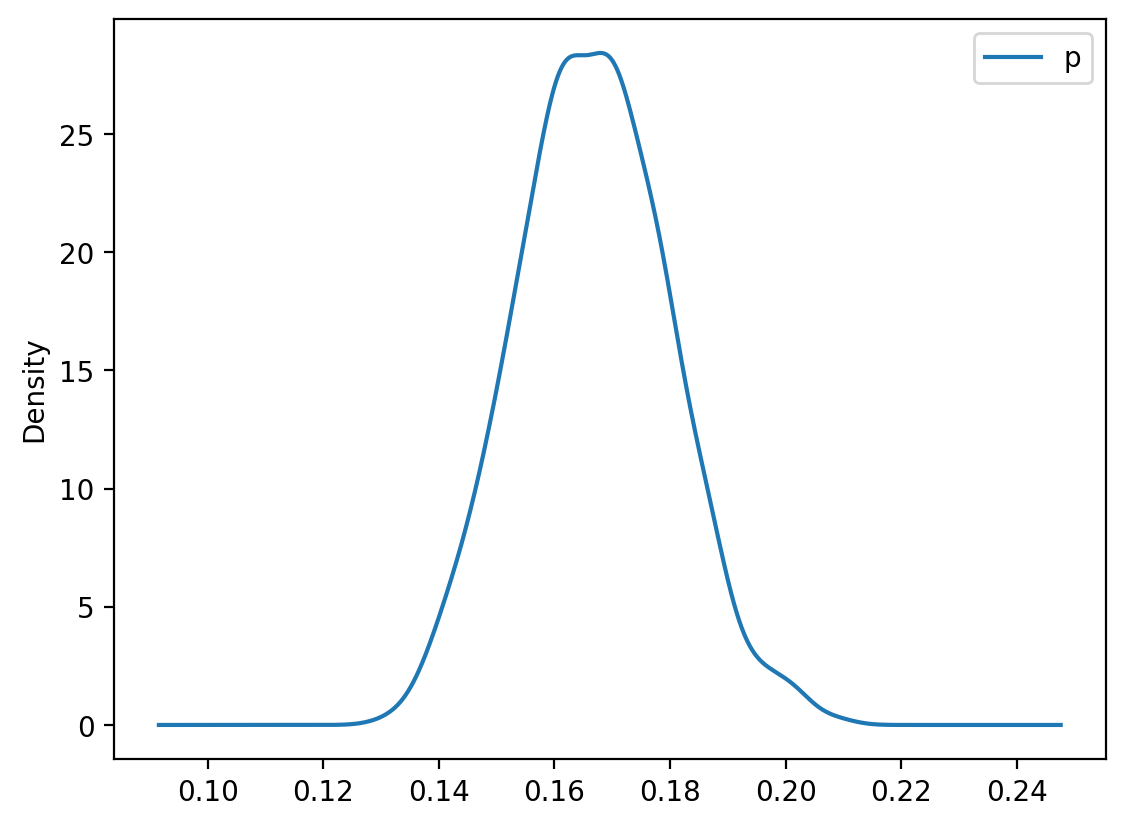

In [2]:

prior = np.random.binomial(total, 1/6, 1000) / total

data = pd.DataFrame(prior, columns=['p'])

data.plot.kde()


Next we construct a model that will sample a Bernoulli distribution on the basis of our observations. We will set a *flat prior* (pm.Uniform) on the proportion of blue color, allowing it to vary from 0 to 1. By doing this we express indifference towards the actual color distribution -- we deem it equally likely that there may be no blue candies in the sample, or that all the candies in the sample might be blue -- or that every 6th candy would be blue.

pm.Uniform is an uninformative prior that gives the model maximum flexibility. As a general rule we can actually do better and choose more informative priors, based on our existing knowledge -- and indeed, as we shall see, often there are many different priors that can be chosen for a particular problem. However, since we are dealing with a very simple problem these considerations do not play a major part.

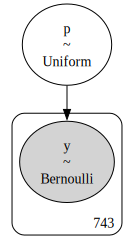

In [3]:

with pm.Model() as mm_model:
    p = pm.Uniform('p', lower=0, upper=1)
    y = pm.Bernoulli('y', p=p, observed=sample)
    
pm.model_to_graphviz(mm_model)
    

Next it is generally a good idea to run a prior predictive check to see what does our model do *before* it has seen any data.

In [4]:
with mm_model:
    pp = pm.sample_prior_predictive()

print(pp.prior.p)

alt.Chart(pd.DataFrame(pp.prior.p[0], columns=['p'])).mark_tick().encode(
    x='p'
).properties(width=500)

Sampling: [p, y]


<xarray.DataArray 'p' (chain: 1, draw: 500)> Size: 4kB
array([[0.2527856 , 0.55515191, 0.01936246, 0.29353623, 0.54407503,
        0.3371092 , 0.49460017, 0.97927883, 0.30806063, 0.17887774,
        0.14890593, 0.5591699 , 0.01809771, 0.68641309, 0.62957443,
        0.58952638, 0.76934891, 0.21040378, 0.94750395, 0.42203602,
        0.94494898, 0.81202768, 0.24589307, 0.54855132, 0.38461794,
        0.99652547, 0.57837522, 0.32813325, 0.64434399, 0.18063149,
        0.08305647, 0.32045044, 0.63282339, 0.88817924, 0.71624784,
        0.58123989, 0.31785917, 0.06751345, 0.71408598, 0.25733238,
        0.42434189, 0.06685609, 0.09713306, 0.15065645, 0.84915995,
        0.68623742, 0.95183689, 0.81167765, 0.05212336, 0.72082359,
        0.4774744 , 0.63454092, 0.97357618, 0.60688504, 0.45691437,
        0.65827886, 0.33535408, 0.604887  , 0.03109478, 0.63735988,
        0.31592353, 0.59732806, 0.40093843, 0.44668154, 0.03150168,
        0.46869322, 0.49645983, 0.97804455, 0.70367197, 0.242

alt.Chart(...)

OK, everything is as expected, so we're ready to push the button and run the model with the data.

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.


array([[<Axes: title={'center': 'p'}>, <Axes: title={'center': 'p'}>]],
      dtype=object)

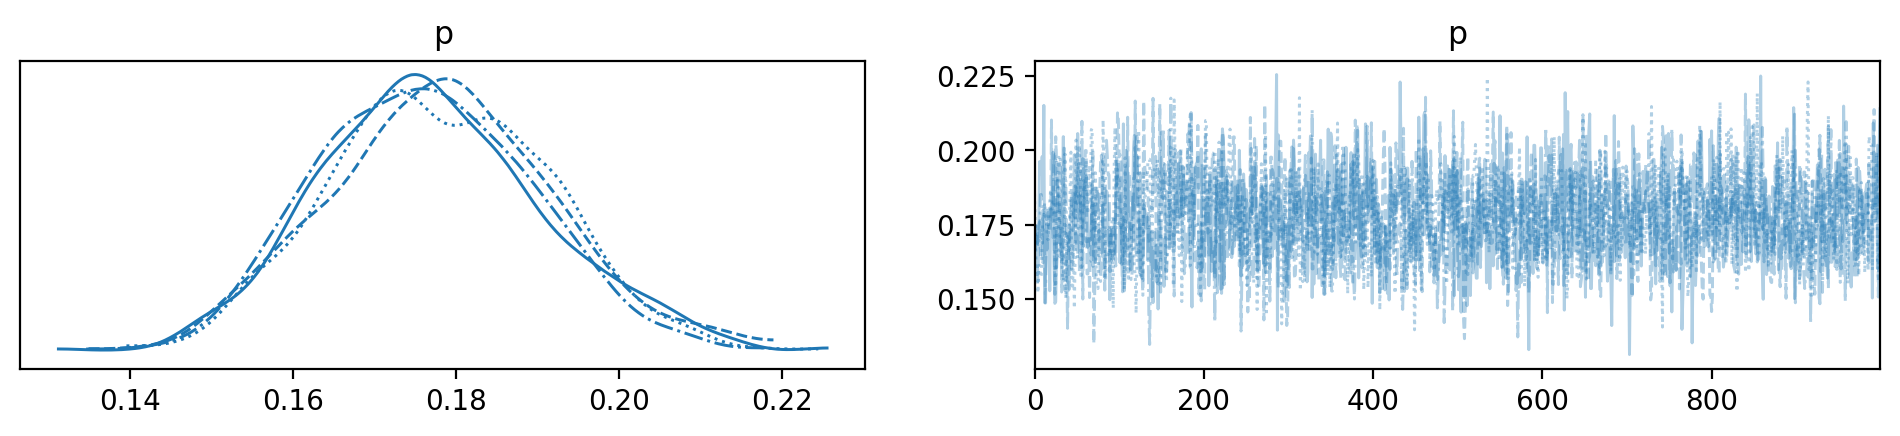

In [5]:
with mm_model:
    trace = pm.sample()

pm.plot_trace(trace)

Next we check the model run diagnostics (a lot more about that later) and plot the posterior distribution against the reference value of 1/6.

    mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
p  0.177  0.014    0.15    0.202        0.0      0.0    1739.0    2957.0   

   r_hat  
p    1.0  


<Axes: title={'center': 'p'}>

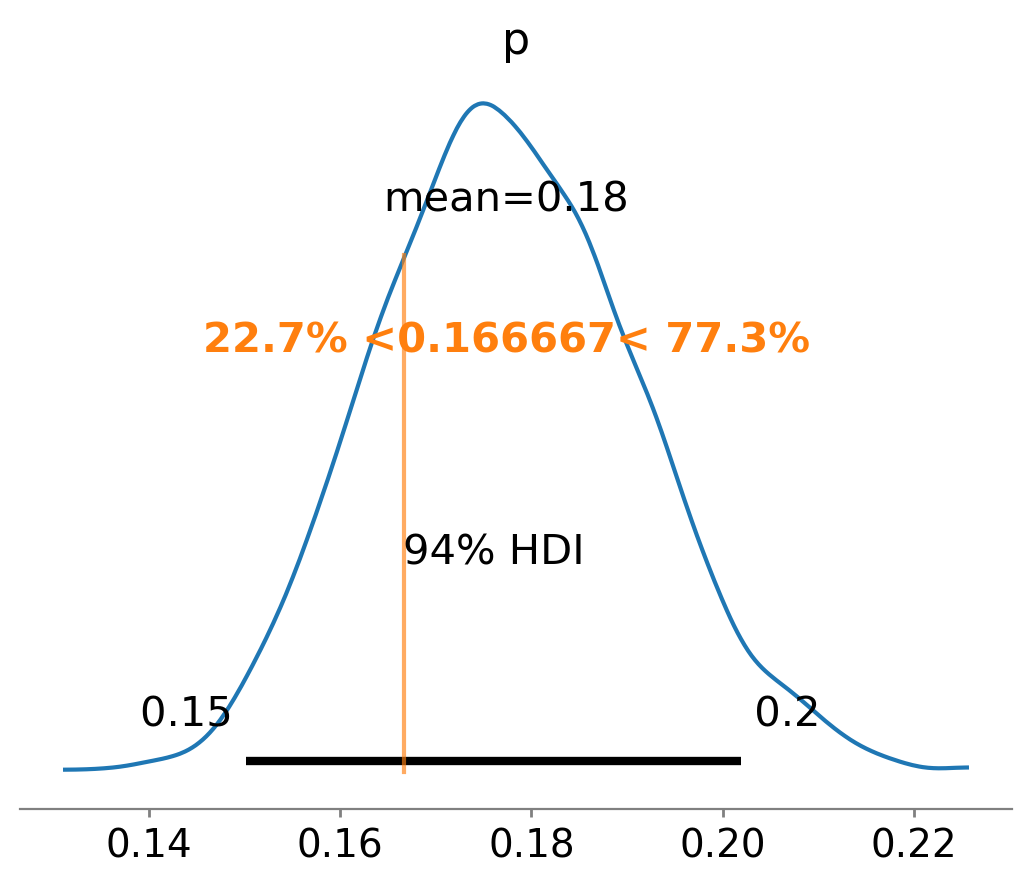

In [6]:
print(pm.summary(trace))

az.plot_posterior(trace, ref_val=(1/6))

Let's look at prior and posterior comparison.

In [9]:

prior_plot = alt.Chart(data).transform_density(
    'p',
    as_=['p', 'density'],
    #bandwidth = 0.05
).mark_area(opacity=0.5).encode(
    x="p:Q",
    y='density:Q',
)

posterior = pd.DataFrame(trace.posterior.p[0], columns=['p'])

post_plot = alt.Chart(posterior, width=400).transform_density(
    'p',
    as_=['p', 'density'],
    #bandwidth = 0.05
).mark_area(opacity=0.5, color='pink').encode(
    x="p:Q",
    y='density:Q',
)

post_plot + prior_plot

alt.LayerChart(...)

However, if we are interested in *contrast*, we will have to calculate and plot the posterior distribution of *difference* from the expectation:

the probability mass over 0: 71.5%


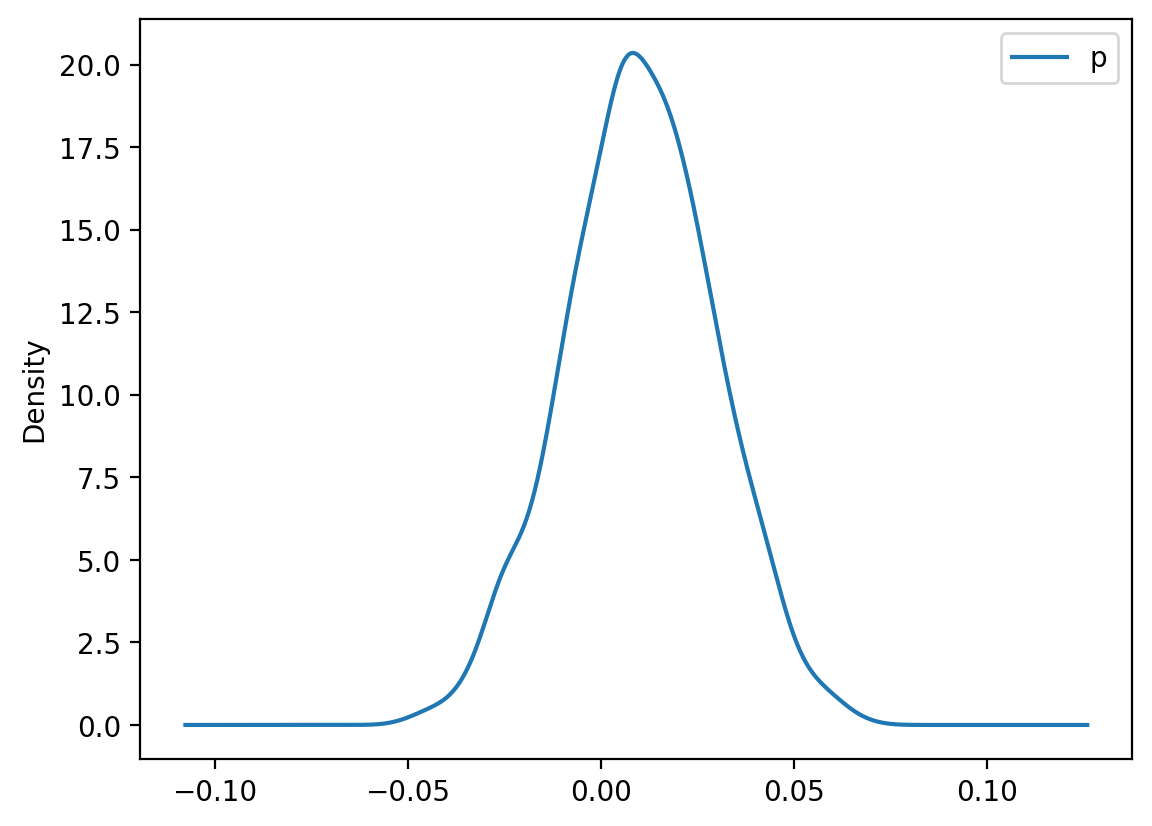

In [10]:
post_diff = posterior - data

(post_diff).plot.kde()

print(f"the probability mass over 0: {(post_diff.p > 0).sum() / len(post_diff):.1%}")

In [19]:
import scipy.stats as stats

def posterior_grid(grid=10, a=2, b=2, blue=5, trials=20):
    grid_vals = np.linspace(0, 1, grid)
    prior = stats.beta(a,b).pdf(grid_vals) #stats.beta(a, b).pdf(grid_vals)
    likelihood = stats.binom.pmf(blue, trials, grid_vals)
    posterior = likelihood * prior
    posterior /= posterior.sum()
    
    data = pd.DataFrame({
        "Probability": np.tile(grid_vals, 3),
        "Density": np.concatenate([prior, likelihood, posterior]),
        "Type": np.repeat(["Prior", "Likelihood", "Posterior"], grid)
    })
    
    chart = alt.Chart(data).mark_line(point=True).encode(
        x=alt.X("Probability", title="p(Blue)"),
        y=alt.Y("Density", title="Density"),
        color=alt.Color("Type").legend(None),
        facet=alt.Facet("Type:N", columns=3, sort=["Prior", "Likelihood", "Posterior"]).title(None),
        tooltip=[
            alt.Tooltip('Probability', format='.2%'), 
            alt.Tooltip('Density', format='.2f')]
    ).properties(
        width=250,
        height=200,
        title=f"Blue = {blue}, Trials = {trials}"
    )#.resolve_scale(y="independent")
    
    return chart

posterior_grid(grid=25, blue=6, trials=20)

alt.Chart(...)

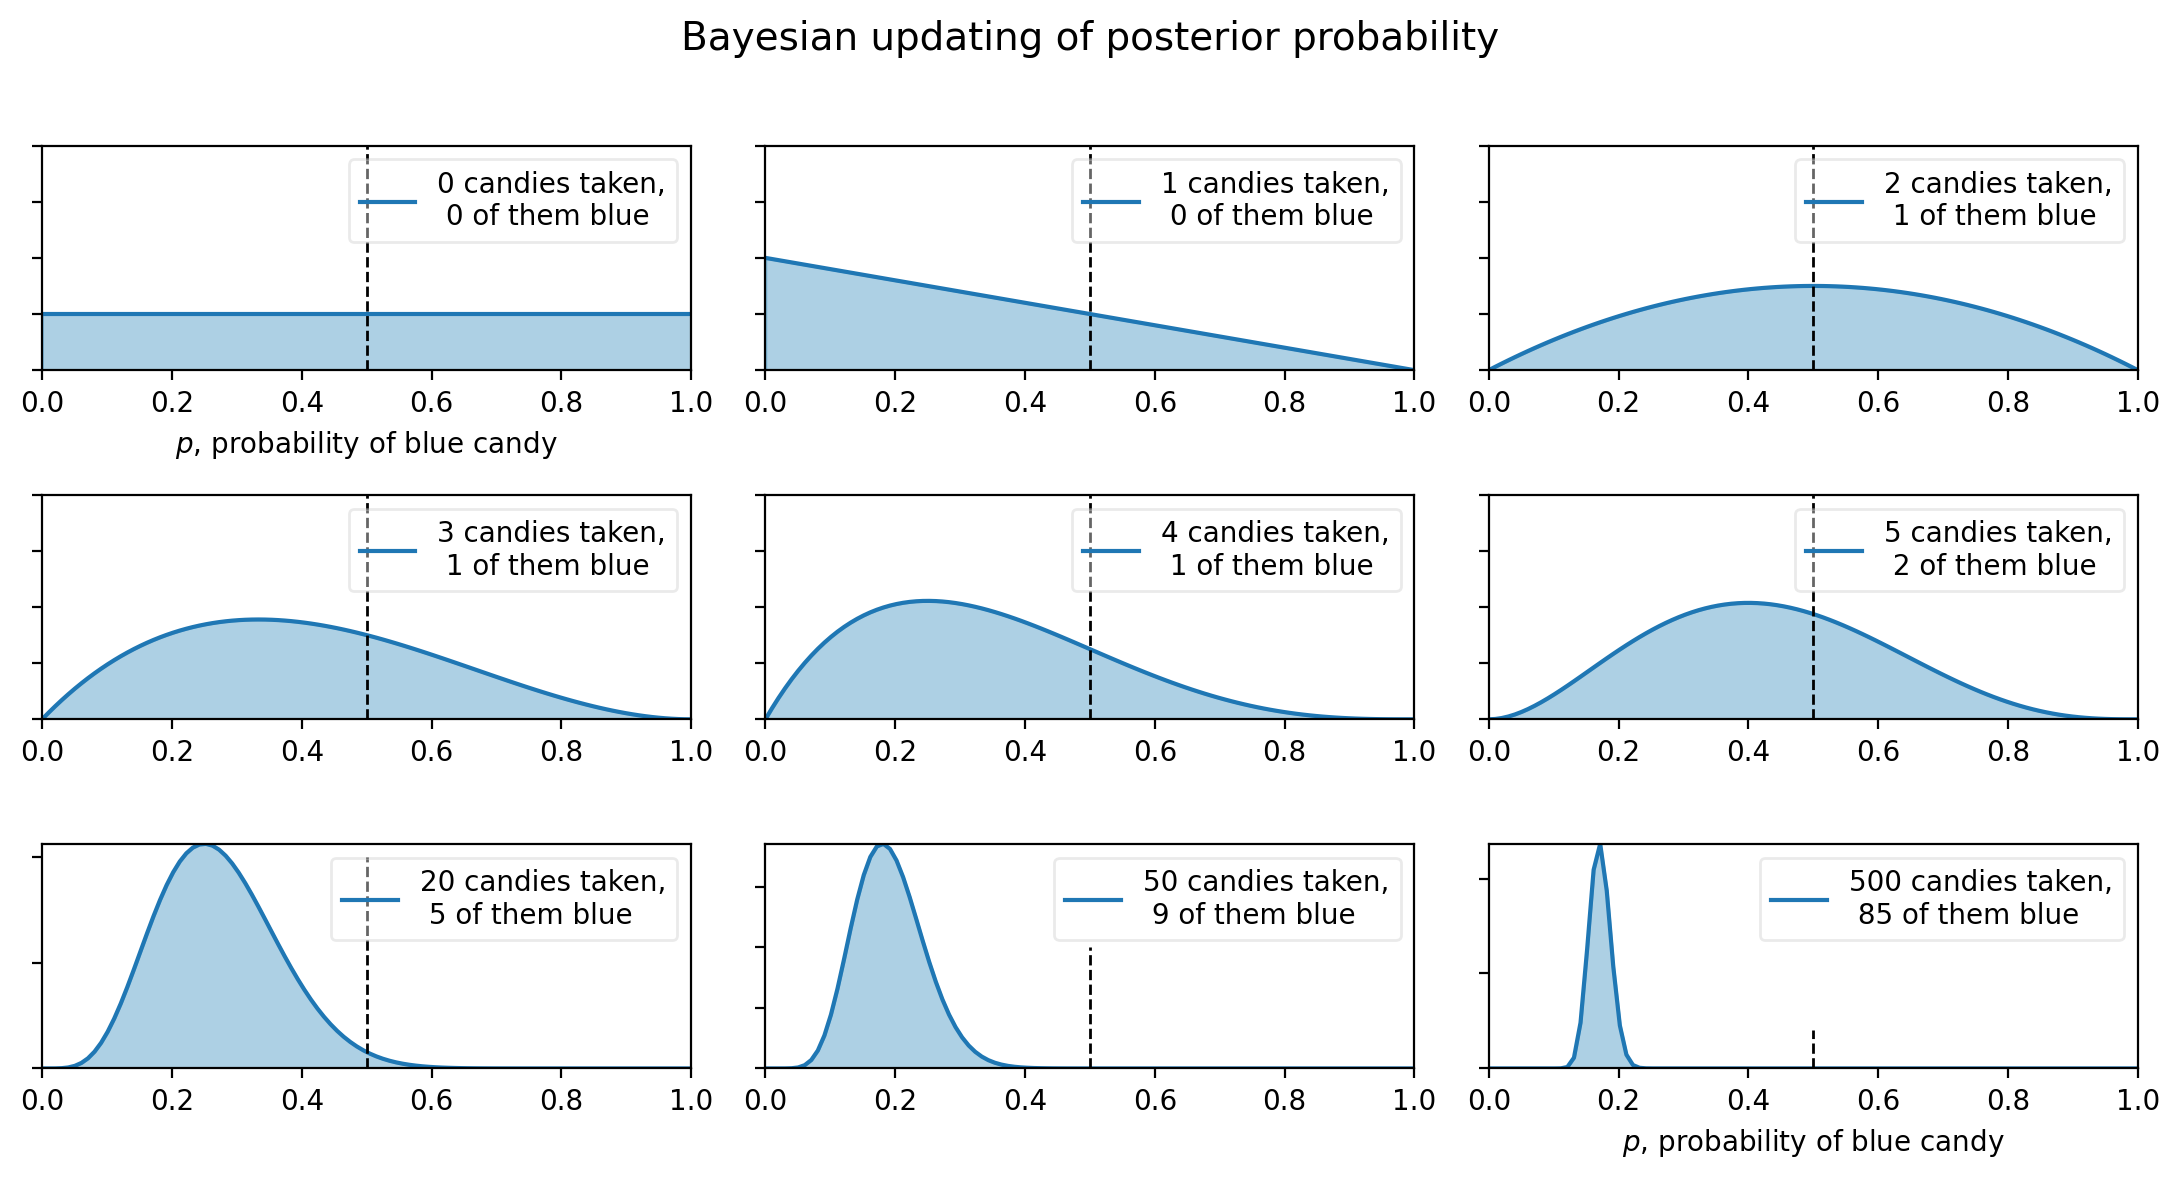

In [20]:

%matplotlib inline
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt 

import scipy.stats as stats

figsize(11, 7)

dist = stats.beta
n_trials = [0, 1, 2, 3, 4, 5, 20, 50, 500]
data = stats.bernoulli.rvs(trace.posterior.p.mean(), size=n_trials[-1])
x = np.linspace(0, 1, 100)

for k, N in enumerate(n_trials):
    sx = plt.subplot(len(n_trials)//2, 3, k+1)
    plt.xlabel("$p$, probability of blue candy") \
        if k in [0, len(n_trials)-1] else None
    plt.setp(sx.get_yticklabels(), visible=False)
    heads = data[:N].sum()
    y = dist.pdf(x, 1 + heads, 1 + N - heads)
    plt.plot(x, y, label="%d candies taken,\n %d of them blue" % (N, heads))
    plt.fill_between(x, 0, y, color="#348ABD", alpha=0.4)
    plt.vlines(0.5, 0, 4, color="k", linestyles="--", lw=1)

    leg = plt.legend()
    leg.get_frame().set_alpha(0.4)
    plt.autoscale(tight=True)


plt.suptitle("Bayesian updating of posterior probability",
             y=1.02,
             fontsize=14)

plt.tight_layout()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, p]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'p'}>, <Axes: title={'center': 'p'}>]],
      dtype=object)

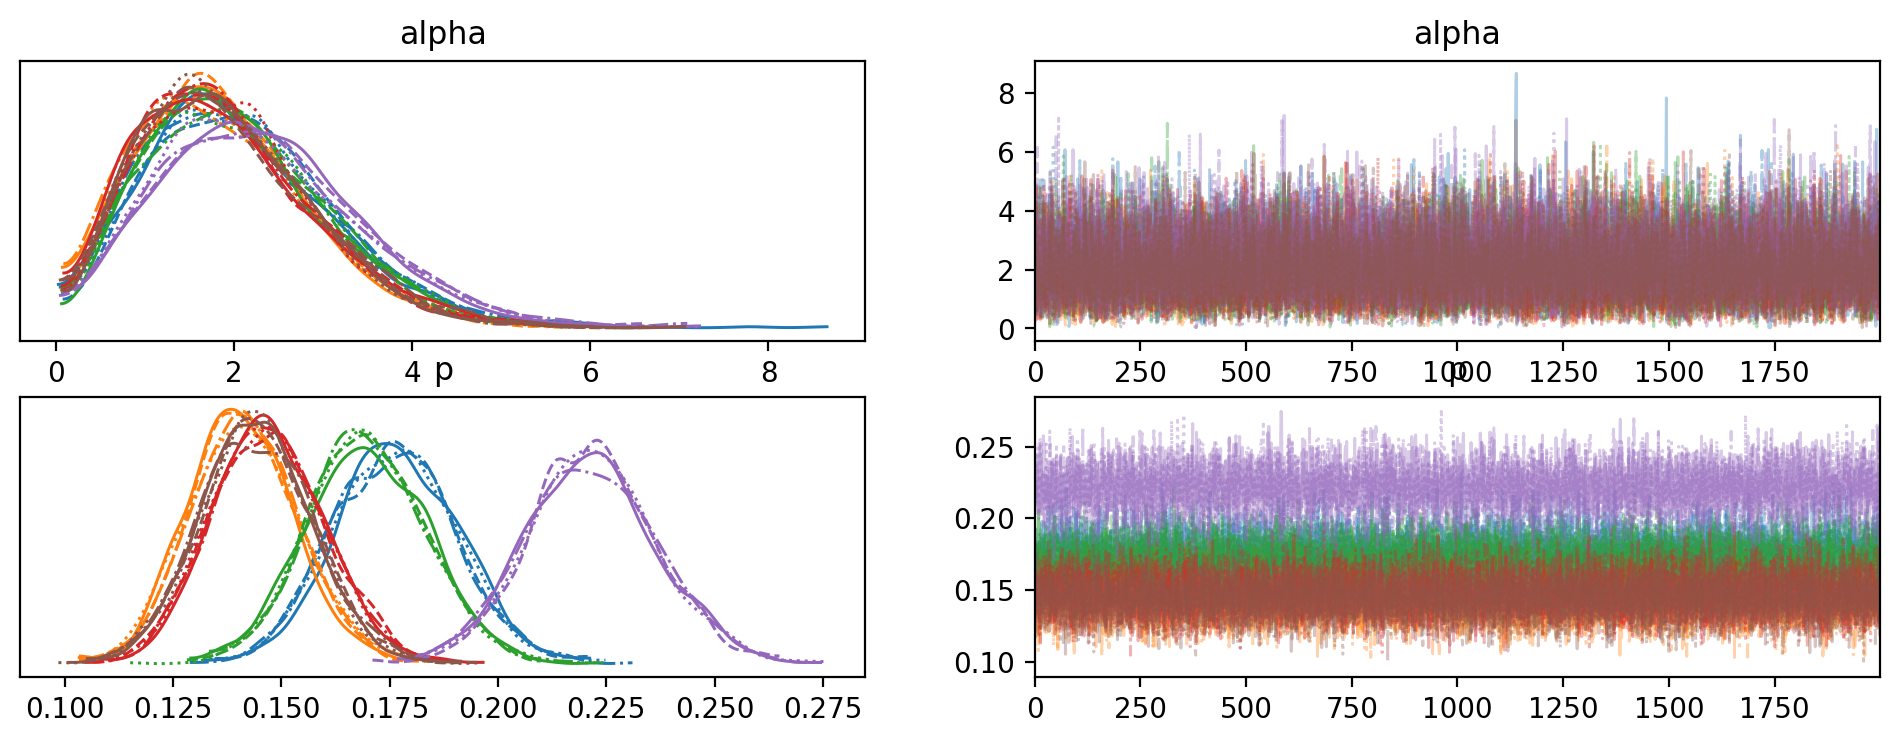

In [69]:
# Prepare data for modeling
data_counts = df.values
num_bags, num_colors = data_counts.shape
color_names = df.columns.tolist()

# Multinomial regression with PyMC
with pm.Model(coords={"colors": color_names}) as model:
    # Dirichlet prior for the category probabilities
    alpha = pm.HalfNormal("alpha", sigma=2, shape=num_colors)
    p = pm.Dirichlet("p", a=alpha, dims="colors")

    # Multinomial likelihood
    likelihood = pm.Multinomial(
        "likelihood",
        n=data_counts.sum(axis=1),  # Total counts per bag
        p=p,
        observed=data_counts
    )

    # Sampling
    trace = pm.sample(2000, tune=1000, target_accept=0.9, return_inferencedata=True)

# Summarize the results
az.plot_trace(trace) #, kind='rank_bars')

In [70]:
az.summary(trace, var_names="p")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p[Blue],0.176,0.014,0.149,0.202,0.0,0.0,7896.0,6549.0,1.0
p[Green],0.141,0.012,0.119,0.165,0.0,0.0,7899.0,6439.0,1.0
p[Yellow],0.170,0.014,0.145,0.196,0.0,0.0,7085.0,4969.0,1.0
p[Red],0.147,0.013,0.123,0.171,0.0,0.0,8156.0,5666.0,1.0
p[Orange],0.222,0.015,0.194,0.250,0.0,0.0,6795.0,5986.0,1.0
p[Brown],0.144,0.013,0.121,0.169,0.0,0.0,11589.0,6264.0,1.0


In [71]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [31]:
from patsy import dmatrix

def generate_spline_basis(data, xdim='year', degree=2, n_bases=10):
    n_knots = n_bases - 1
    knots = np.quantile(data[xdim], np.linspace(0, 1, n_knots))
    return dmatrix(
        f"bs({xdim}, knots=knots, degree={degree}, include_intercept=True) - 1",
        {xdim: data[xdim], "knots": knots[1:-1]}
    )

def fit_spline_model(data, xdim, ydim, n_bases=10):
    basis_set = generate_spline_basis(data, xdim, n_bases=n_bases).base
    with pm.Model() as spline_model:

        # Priors
        sigma = pm.Exponential("sigma", 1)
        alpha = pm.Normal("alpha", data[ydim].mean(), data[ydim].std())
        beta = pm.Normal("beta", 0, 25, shape=n_bases)

        # Likelihood
        mu = pm.Deterministic("mu", alpha + pm.math.dot(basis_set, beta.T))
        pm.Normal("ydim_obs", mu, sigma, observed=data[ydim].values)

        spline_inference = pm.sample(target_accept=.95)
        
    _, ax = plt.subplots(figsize=(10, 3))
    plt.scatter(
        x=data[xdim],
        y=data[ydim]
    )
    az.plot_hdi(
        data[xdim],
        spline_inference.posterior["mu"],
        color='k',
        hdi_prob=.89,
        fill_kwargs=dict(alpha=.3, label='Posterior Mean')
    )
    plt.legend(loc='lower right')
    plt.xlabel(f"{xdim}")
    plt.ylabel(f"{ydim}");
    
    return spline_model, spline_inference, basis_set

In [29]:
hw = pd.read_csv('./data/height_weight_gender.csv')
hw.head()

,Gender,Height,Weight,Age
0,0,1.875718,109.702296,47
1,0,1.747064,73.610192,36
2,0,1.882400,96.481114,45
3,0,1.821970,99.792504,46
4,0,1.775001,93.582676,22


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, beta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


(   sigma ~ Exponential(f())
    alpha ~ Normal(72.7, 14.8)
     beta ~ Normal(0, 25)
       mu ~ Deterministic(f(beta, alpha))
 ydim_obs ~ Normal(mu, sigma),
 Inference data with groups:
 	> posterior
 	> sample_stats
 	> observed_data,
 array([[0.        , 0.09588312, 0.84392277, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.09321686, 0.52696786, 0.37981528, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.00934874, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]]))

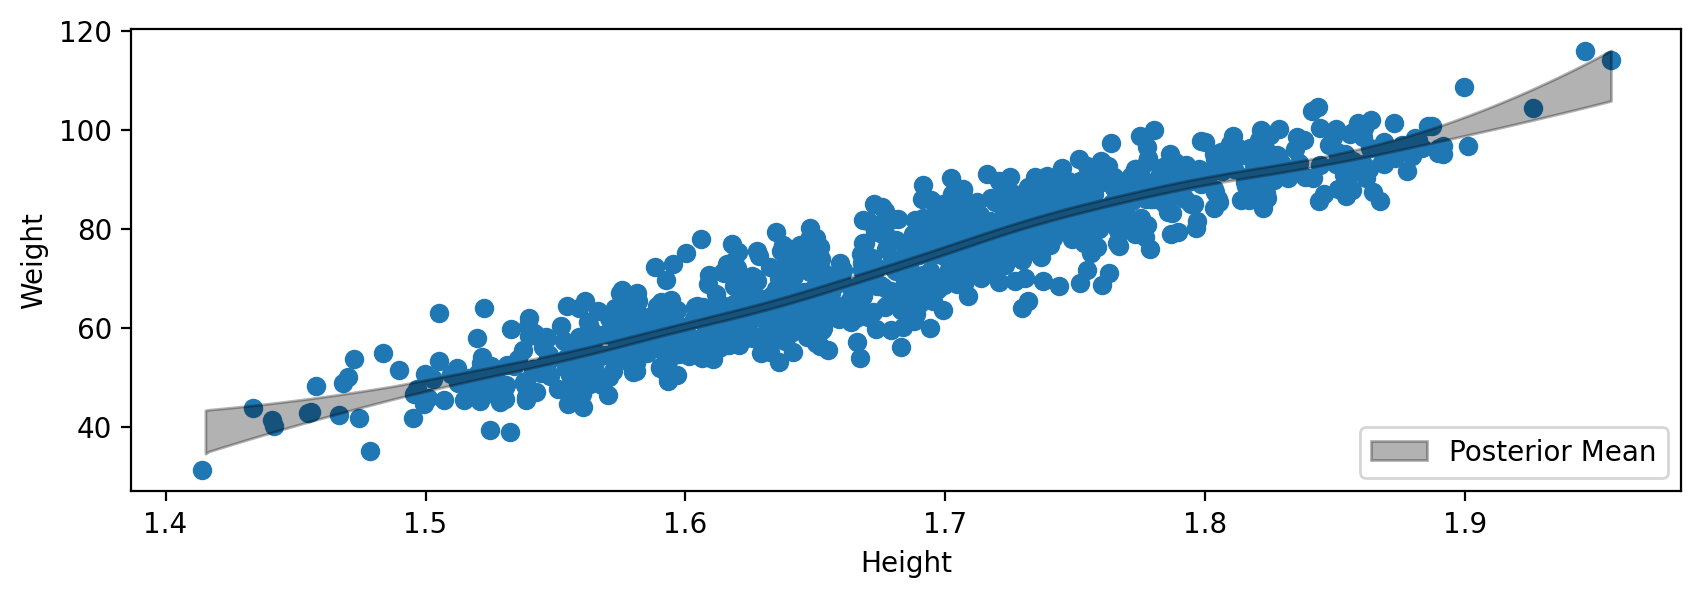

In [38]:
fit_spline_model(hw.sample(1000), 'Height', 'Weight')